# Preliminary Time Series Modeling

In [1]:
import pandas as pd
import numpy as np 

In [2]:
# Import test and train data
test = pd.read_feather('data/test.feather')
train = pd.read_feather('data/train.feather')

In [3]:
test.head()

,TOTALKWH,tempAvg,winddirAvg,population,density,YEAR_MONTH,zipcode,latitude,longitude
52193,2117994.0,53.976667,224.700000,9013.0,20.5,2023-12-01,95322.0,37.17622,-121.01861
52190,1780629.0,42.333333,160.133333,3870.0,3.3,2023-12-01,95321.0,37.97719,-119.75012
50326,27640625.0,55.320000,257.533333,14890.0,11395.1,2023-12-01,94105.0,37.79239,-122.39707
52187,3131019.0,50.713333,205.866667,13511.0,58.8,2023-12-01,95320.0,37.82453,-121.01545
52184,125501.0,46.913333,159.433333,572.0,3.9,2023-12-01,95318.0,37.66618,-119.80640


In [4]:
train.head()

,TOTALKWH,tempAvg,winddirAvg,population,density,YEAR_MONTH,zipcode,latitude,longitude
1309,2182898.0,53.025806,220.129032,11336.0,98.3,2020-01-01,93442.0,35.40000,-120.80495
983,1496217.0,47.587097,199.516129,13314.0,224.7,2020-01-01,95650.0,38.81339,-121.16831
3178,35884.0,32.200000,220.000000,0.0,0.0,2020-01-01,95721.0,38.82341,-120.09379
1996,2902710.0,47.096774,187.451613,7646.0,23.8,2020-01-01,94574.0,38.52742,-122.39261
980,6517919.0,49.122581,176.096774,56597.0,151.4,2020-01-01,95648.0,38.92643,-121.31101


Based on the data procecssing steps, it is observced that TOTALKWH, tempAvg, winddirAvg features are time series data and have displayed seasonal changes, whereas population and density are non-seasonal static predictors. Therefore, instead of pure ARIMA/SARIMA (they don't handle external predictors well), I will be using supervised ML models with lag features. 

In [5]:
# Convert YEAR_MONTH to extract time features
train['month'] = train['YEAR_MONTH'].dt.month
train['year'] = train['YEAR_MONTH'].dt.year
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)

test['month'] = test['YEAR_MONTH'].dt.month
test['year'] = test['YEAR_MONTH'].dt.year
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)

In [6]:
# Create lag and rolling features
train['lag_1'] = train['TOTALKWH'].shift(1)
train['lag_12'] = train['TOTALKWH'].shift(12)
train['rolling_mean_3'] = train['TOTALKWH'].shift(1).rolling(3).mean()

test['lag_1'] = test['TOTALKWH'].shift(1)
test['lag_12'] = test['TOTALKWH'].shift(12)
test['rolling_mean_3'] = test['TOTALKWH'].shift(1).rolling(3).mean()

In [7]:
test = test.dropna()
train = train.dropna()


In [8]:
features = ['tempAvg', 'winddirAvg', 'population', 'zipcode', 'longitude', 'latitude', 'density', 'month_sin', 'month_cos', 'lag_1', 'lag_12', 'rolling_mean_3']
X_train = train[features]
y_train = train['TOTALKWH']
X_test = test[features]
y_test = test['TOTALKWH']

all_data = (X_train, y_train, X_test, y_test)

## Code for implement model training with model improvement through GridSearchCV

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

In [10]:
def train_and_cv(model, param_grid, X_train, y_train, fold, model_name):
    """
    Train a model using GridSearchCV with TimeSeriesSplit and collect cross-validation metrics.

    Parameters:
    - model: model instance
    - param_grid: dict, grid of hyperparameters
    - X_train: training features
    - y_train: training labels
    - fold: int, number of folds
    - model_name: str, name of the model

    Returns:
    - best_model: trained model with best parameters
    - cv_metrics: dict, cross-validation metrics
    """
    tscv = TimeSeriesSplit(n_splits=fold)
    scoring = {
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    }
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=tscv,
        scoring=scoring,
        refit='rmse',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_idx = grid_search.best_index_

    # Collect cross-validation metrics
    cv_metrics = {
        'model_name': model_name,
        'rmse_cv_mean': -grid_search.cv_results_['mean_test_rmse'][best_idx],
        'rmse_cv_std': grid_search.cv_results_['std_test_rmse'][best_idx],
        'mae_cv_mean': -grid_search.cv_results_['mean_test_mae'][best_idx],
        'mae_cv_std': grid_search.cv_results_['std_test_mae'][best_idx],
        'r2_cv_mean': grid_search.cv_results_['mean_test_r2'][best_idx],
        'r2_cv_std': grid_search.cv_results_['std_test_r2'][best_idx],
        'rmse_test': None,
        'mae_test': None,
        'r2_test': None
    }
    return best_model, cv_metrics


def evaluate(model, X_test, y_test):
    """
    Evaluate model performance on the test set.

    Parameters:
    - model: trained model
    - X_test: testing features
    - y_test: testing labels

    Returns:
    - rmse, mae, r2: evaluation metrics
    """
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2


def modeling(model, dataset, param_grid, fold, model_name, cat_col=None):
    """
    Complete modeling pipeline: training, evaluation, saving model, and updating metrics.

    Parameters:
    - model: model instance
    - dataset: tuple (X_train, y_train, X_test, y_test)
    - param_grid: dict, grid of hyperparameters
    - fold: int, number of folds
    - model_name: str, model name
    - cat_col: list, categorical columns (optional)

    Returns:
    - best_model: trained best model
    - metrics_row: collected metrics
    """
    if cat_col:
        for col in cat_col:
            dataset[col] = dataset[col].astype('category')

    X_train, y_train, X_test, y_test = dataset

    best_model, metrics_row = train_and_cv(model, param_grid, X_train, y_train, fold, model_name)
    print(f"Cross-Validation RMSE: {metrics_row['rmse_cv_mean']:.4f} ± {metrics_row['rmse_cv_std']:.4f}")
    print(f"Cross-Validation MAE: {metrics_row['mae_cv_mean']:.4f} ± {metrics_row['mae_cv_std']:.4f}")
    print(f"Cross-Validation R2: {metrics_row['r2_cv_mean']:.4f} ± {metrics_row['r2_cv_std']:.4f}")

    rmse_test, mae_test, r2_test = evaluate(best_model, X_test, y_test)
    print(f"Test RMSE: {rmse_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test R2: {r2_test:.4f}")

    metrics_row['rmse_test'] = rmse_test
    metrics_row['mae_test'] = mae_test
    metrics_row['r2_test'] = r2_test

    return best_model, metrics_row

In [11]:
# Plot the data 
def plot_best_model(best_model, X_test, y_test): 
    results = pd.DataFrame({
        'YEAR_MONTH': test['YEAR_MONTH'].values,
        'Actual': y_test.values,
        'Predicted': best_model.predict(X_test)
    })

    # Sort by time (just in case)
    results = results.sort_values('YEAR_MONTH')

    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(results['YEAR_MONTH'], results['Actual'], label='Actual', marker='o')
    plt.plot(results['YEAR_MONTH'], results['Predicted'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('TOTALKWH')
    plt.title('Actual vs Predicted TOTALKWH Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Linear Regression

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Cross-Validation RMSE: 16251618.9805 ± 1825617.7663
Cross-Validation MAE: 4364329.5578 ± 355100.4921
Cross-Validation R2: 0.1248 ± 0.0331
Test RMSE: 13848802.2595
Test MAE: 4541057.9792
Test R2: 0.1713


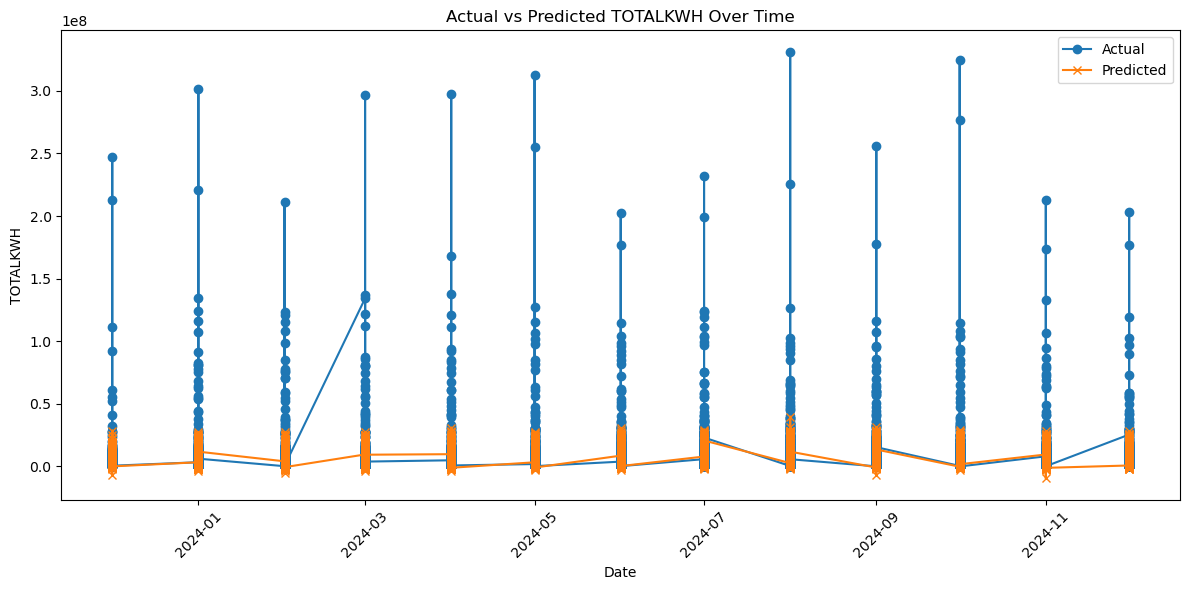

In [12]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
param_grid_lr = {}
best_model, metrics_row = modeling(linear_regression, all_data, param_grid_lr, 10, 'Linear Regression')

plot_best_model(best_model, X_test, y_test)

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
param_grid_rf = {
    'max_depth': [10, 20],        # Maximum depth of each tree
    'min_samples_split': [5, 10],       # Minimum samples to split an internal node
    #'max_features': ['sqrt', 'log2', 0.8], # Number of features to consider when splitting
    'bootstrap': [True, False]             # Whether to bootstrap samples
}
best_model, metrics_row = modeling(random_forest, all_data, param_grid_rf, 10, 'Random Forest')

plot_best_model(best_model, X_test, y_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


KeyboardInterrupt: 

XG Boost Regressor Model

In [8]:
import xgboost as xgb

In [9]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

In [10]:
# Split features
features = ['tempAvg', 'winddirAvg', 'population', 'zipcode', 'longitude', 'latitude', 'density', 'month_sin', 'month_cos', 'lag_1', 'lag_12', 'rolling_mean_3']
X_train = train[features]
y_train = train['TOTALKWH']
X_test = test[features]
y_test = test['TOTALKWH']

# Fit the model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R Square Score: {r2}")

Root Mean Squared Error: 13160897.648599511
Mean Absolute Error: 4011663.1176081006
R Square Score: 0.2516773224930302


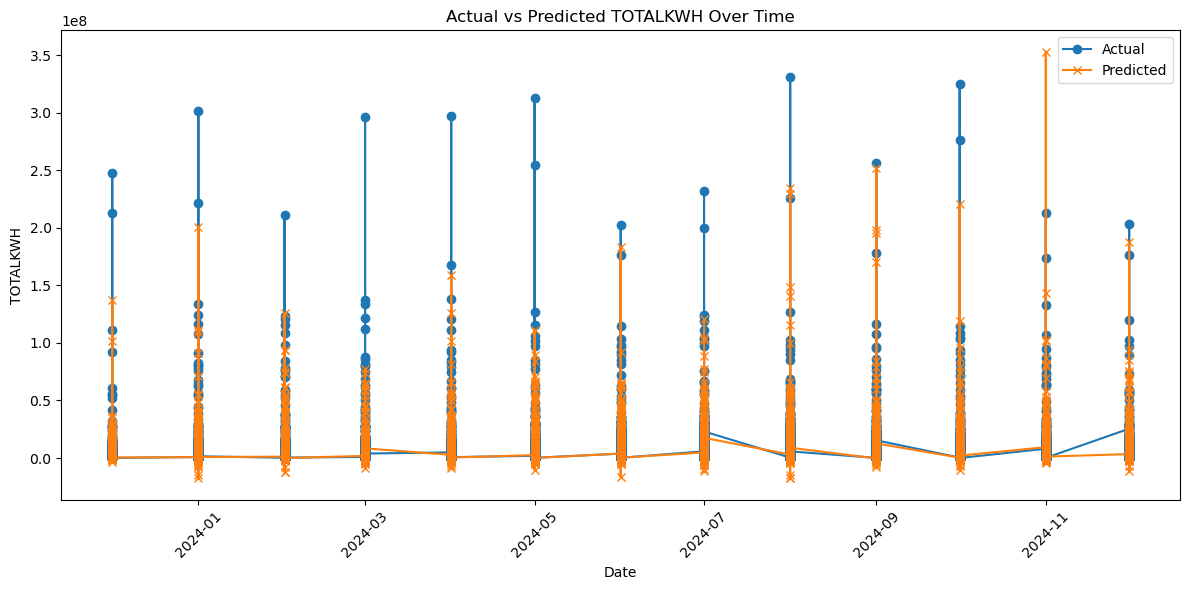

In [11]:
# Plot the results
results = pd.DataFrame({
    'YEAR_MONTH': test['YEAR_MONTH'].values,
    'Actual': y_test.values,
    'Predicted': y_pred
})

# Sort by time (just in case)
results = results.sort_values('YEAR_MONTH')

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results['YEAR_MONTH'], results['Actual'], label='Actual', marker='o')
plt.plot(results['YEAR_MONTH'], results['Predicted'], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('TOTALKWH')
plt.title('Actual vs Predicted TOTALKWH Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Fit the model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R Square Score: {r2}")